In [2]:
import os
import math
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as data
import torchvision
from torchvision import transforms

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style

style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

In [3]:
EPOCHS = 10
BATCH_SIZE = 30
LEARNING_RATE = 0.003
IMG_SIZE = 64
CONV_SIZE = math.floor((((IMG_SIZE-2)/2)-2)/2)

TRAIN_DATA_PATH = "C:/Users/Administrator/Desktop/programming/datasets/images/flowers_train_test/train"
TEST_DATA_PATH = "C:/Users/Administrator/Desktop/programming/datasets/images/flowers_train_test/test"

TRANSFORM_IMG = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])])

train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
train_data_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)
test_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG)
test_data_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

In [4]:
print(len(train_data))
print(len(test_data))
train_data.classes

3813
510


['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [5]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 3, 1)
        self.conv2 = nn.Conv2d(8, 16, 3, 1)
        self.fc1 = nn.Linear(CONV_SIZE**2*16, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, CONV_SIZE**2*16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x

In [6]:
CNNmodel = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNNmodel.parameters(), lr=LEARNING_RATE)

In [7]:
import time
start_time = time.time()

train_loss = []
test_loss = []
train_correct = []
test_correct = []

for i in range(EPOCHS):
    train_count = 0
    test_count = 0
    
    for b, (X_train, y_train) in enumerate(train_data_loader):
        
        b+=1
        
        y_pred = CNNmodel(X_train)
        loss = criterion(y_pred, y_train)
 
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        train_count += batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b%30 == 0:
            print(f'epoch: {i}   batch: {int(b/30)}   loss: {loss.item():.6f}')

    train_loss.append(loss)
    train_correct.append(train_count)

    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_data_loader):
            
            y_val = CNNmodel(X_test)

            predicted = torch.max(y_val.data, 1)[1] 
            test_count += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_loss.append(loss)
    test_correct.append(test_count)

print(f'\nTime: {time.time() - start_time:.0f} s')

epoch: 0   batch: 1   loss: 1.143551
epoch: 0   batch: 2   loss: 1.252975
epoch: 0   batch: 3   loss: 0.960164
epoch: 0   batch: 4   loss: 0.935244
epoch: 1   batch: 1   loss: 0.882461
epoch: 1   batch: 2   loss: 1.186185
epoch: 1   batch: 3   loss: 0.891134
epoch: 1   batch: 4   loss: 1.093329
epoch: 2   batch: 1   loss: 0.829615
epoch: 2   batch: 2   loss: 0.800176
epoch: 2   batch: 3   loss: 0.613306
epoch: 2   batch: 4   loss: 0.649757
epoch: 3   batch: 1   loss: 0.887192
epoch: 3   batch: 2   loss: 0.566145
epoch: 3   batch: 3   loss: 0.726783
epoch: 3   batch: 4   loss: 0.617219
epoch: 4   batch: 1   loss: 0.431828
epoch: 4   batch: 2   loss: 0.296089
epoch: 4   batch: 3   loss: 0.441438
epoch: 4   batch: 4   loss: 0.546957
epoch: 5   batch: 1   loss: 0.191591
epoch: 5   batch: 2   loss: 0.326776
epoch: 5   batch: 3   loss: 0.119922
epoch: 5   batch: 4   loss: 0.438820
epoch: 6   batch: 1   loss: 0.037576
epoch: 6   batch: 2   loss: 0.305362
epoch: 6   batch: 3   loss: 0.126946
e

In [8]:
torch.save(CNNmodel.state_dict(), 'cnn_model.pt')

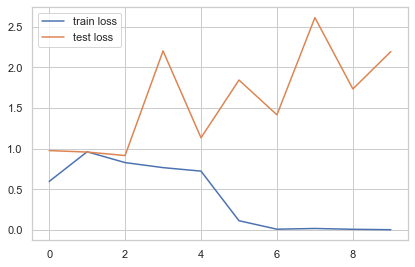

In [9]:
plt.plot(train_loss, label='train loss')
plt.plot(test_loss, label='test loss')
plt.legend()

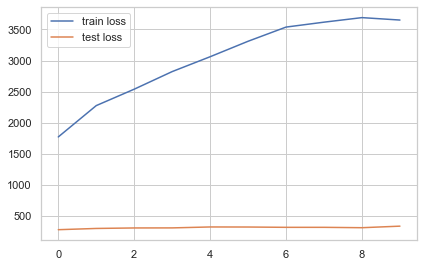

In [10]:
plt.plot(train_correct, label='train correct')
plt.plot(test_correct, label='test correct')
plt.legend()